In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.optimize import minimize
from autograd import grad

data = pd.read_csv('ratings_small.csv') # https://www.kaggle.com/code/krishcross/netflix-s-movie-recommendation-system/data, include "ratings_small.csv"

In [ ]:
# r = data.set_index(['userId', 'movieId'])['rating'].unstack(1)
# print(r)
# Distribution of ratings
Counter(data.rating)

Counter({1.0: 5, 2.0: 12, 2.5: 6, 3.0: 65, 3.5: 10, 4.0: 49, 4.5: 4, 5.0: 48})

In [ ]:
# Number of ratings per user
Counter(data.groupby(['userId']).count()['movieId'])

In [3]:
#Average number of ratings per user
np.mean(data.groupby(['userId']).count()['movieId'])

149.03725782414307

# Intialization

In [5]:
# for fixed model, we do not need the development set. indeed we only need training set and testing set
train_set, test_set = train_test_split(data, test_size=0.2)    #### which proportion we should choose????????
#resetting indices to avoid indexing errors in the future
train_set = train_set.reset_index()[['userId', 'movieId', 'rating']]
test_set = test_set.reset_index()[['userId', 'movieId', 'rating']]
print('train_set:\n',train_set)
print('test_set:\n',test_set)

train_set:
        userId  movieId  rating
0         311     2076     3.0
1         282     3107     3.5
2         664       70     3.5
3         292     6863     3.5
4         547     3685     1.0
...       ...      ...     ...
79998     358     1566     4.0
79999     291     1275     4.5
80000     128     5991     5.0
80001     283     7254     1.0
80002     486    79132     3.5

[80003 rows x 3 columns]
test_set:
        userId  movieId  rating
0         113      140     5.0
1         547     4787     3.0
2          90       79     3.0
3         387     2300     4.0
4         380     2353     3.5
...       ...      ...     ...
19996     561     4306     3.5
19997     624     2628     2.0
19998     204      112     2.5
19999     260    44191     5.0
20000      99     2135     1.0

[20001 rows x 3 columns]


In [6]:
def encode_column(column):
    """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [7]:
def encode_df(train_set):
    """Encodes rating data with continuous user and anime ids"""
    movie_ids, train_set['movieId'], num_movies = encode_column(train_set['movieId'])
    user_ids, train_set['userId'], num_users = encode_column(train_set['userId'])
    return train_set, num_users, num_movies, user_ids, movie_ids

In [8]:
train_set, number_users, number_movies, user_ids, movie_ids = encode_df(train_set)
print("Number of users :", number_users)
print("Number of movies :", number_movies)

Number of users : 671
Number of movies : 8388


In [9]:
test_set,number_users1, number_movies1, user_ids1, movie_ids1 = encode_df(test_set)

initialize the random u and v function

n: number of items/users

K: number of factors in the embedding

### Create embedding matrices

k=1 or 2 or 5

In [10]:
def initialize_random_u_and_v(n, K):
    return 5 * np.random.random((n, K)) / K

In [11]:
random_u = initialize_random_u_and_v(number_users, 1)
random_v = initialize_random_u_and_v(number_movies, 1)
print(random_u.shape,random_v.shape)

(671, 1) (8388, 1)


In [ ]:
random_u = initialize_random_u_and_v(number_users, 2)
random_v = initialize_random_u_and_v(number_movies, 2)
print(random_u.shape,random_v.shape)

In [ ]:
random_u = initialize_random_u_and_v(number_users, 5)
random_v = initialize_random_u_and_v(number_movies, 5)
print(random_u.shape,random_v.shape)

### Prediction function

In [12]:
def prediction(train_set, random_u, random_v):
    train_set['prediction'] = np.sum(np.multiply(random_u[train_set['userId']],random_v[train_set['movieId']]), axis=1)
    return train_set

creat sparse matrix


In [13]:
def create_sparse_matrix(df, rows, cols, column_name="rating"):
    """ Returns a sparse utility matrix""" 
    return sparse.csc_matrix((df[column_name].values,(df['userId'].values, df['movieId'].values)),shape=(rows, cols))

create dense matrix

In [ ]:
Y = create_sparse_matrix(train_set, random_u.shape[0], random_v.shape[0])
train_set_den = Y.todense()

### Cost function

In [14]:
def cost(lam, train_set, random_u, random_v):
    """ Computes mean square error"""
    Y = create_sparse_matrix(train_set, random_u.shape[0], random_v.shape[0])
    predicted = create_sparse_matrix(prediction(train_set, random_u, random_v), random_u.shape[0], random_v.shape[0], 'prediction')
    return np.sum((Y-predicted).power(2))/train_set.shape[0] + lam * (np.linalg.norm(random_u) + np.linalg.norm(random_v))

### Gradient function

In [15]:
lmbda=0.000002
def gradient(df, random_u, random_v):
    """ Computes the gradient for user and anime embeddings"""
    Y = create_sparse_matrix(df, random_u.shape[0], random_v.shape[0])
    predicted = create_sparse_matrix(prediction(df, random_u, random_v), random_u.shape[0], random_v.shape[0], 'prediction')
    delta =(Y-predicted)
    grad_user = (-2/df.shape[0])*(delta*random_v) + 2*lmbda*random_u
    grad_moive = (-2/df.shape[0])*(delta.T*random_u) + 2*lmbda*random_v
    return grad_user, grad_moive

# GD

In [ ]:
def gradient_descent(lam, df, random_u, random_v, iterations, learning_rate=0.01, df_val=None):
    """ 
    Computes gradient descent with momentum (0.9) for given number of iterations.
    random_u: the trained user embedding
    random_v: the trained anime embedding
    """
    #Y = create_sparse_matrix(df, random_u.shape[0], random_v.shape[0])
    grad_user, grad_moive = gradient(df, random_u, random_v)
    #v_user = grad_user
    #v_moive = grad_moive
    for i in range(iterations):
        grad_user, grad_moive = gradient(df, random_u, random_v)
        #v_user = 0.9*v_user + (1-0.9)*grad_user
        #v_moive = 0.9*v_moive + (1-0.9)*grad_moive
        random_u = random_u - learning_rate*grad_user
        random_v = random_v - learning_rate*grad_moive
        #print(grad_user, grad_anime)
        if(not (i+1)%50):
            print("\niteration", i+1, ":")
            print("train mse:",  cost(lam, df, random_u, random_v))
            if df_val is not None:
                print("validation mse:",  cost(lam, test_set, random_u, random_v))
    return random_u, random_v

In [ ]:
random_u, random_v = gradient_descent(0.000002, train_set, random_u, random_v, 100, learning_rate=0.2)


iteration 50 :
train mse: 0.012315657499283943

iteration 100 :
train mse: 0.0038755330634736795


# SGD

In [ ]:
train_set_for_sgd = train_set
test_set_for_sgd = test_set

In [ ]:
from numpy import random
import matplotlib.pyplot as plt
def stoch_gd(train_set, random_u, random_v, max_iterations, lam_bda, lr):
  iter = []
  loss = []
  for k in range(max_iterations):
    i = np.random.randint(0, random_u.shape[0])
    j = np.random.randint(0, random_v.shape[0])
    # print(type(j))
    # print(random_u[i])
    cycle = np.floor(1+max_iterations/(2*2000))
    x = np.abs(max_iterations/2000 - 2*cycle + 1)
    lr= 0.0001 + (0.0006-0.0001)*np.maximum(0, (1-x))
    new_u = random_u[i] - lr * (2* (random_u[i] @ random_v[j].T - train_set[i,j]) * random_v[j]) / train_set.shape[0] + 2 * lam_bda * random_u[i]
    new_v = random_v[j] - lr * (2* (random_u[i] @ random_v[j].T - train_set[i,j]) * random_u[i]) / train_set.shape[0] + 2 * lam_bda * random_v[j]

    # print(new_u)
    random_u[i] = new_u
    random_v[j] = new_v
    iter.append(k)
    value = cost(0.000002,train_set_for_sgd,random_u, random_v)
    loss.append(value)
    # if(not (k+1)%50):
            # print("\niteration", k+1, ":")
            # print("train mse:", value)
            
  plt.figure()
  plt.plot(iter,loss)
  plt.show()
  # print((train_set - random_u @ random_v.T))
  # loss = (np.linalg.norm(train_set - random_u @ random_v.T) ** 2) / train_set.shape[0] + lam_bda * (np.linalg.norm(random_u) + np.linalg.norm(random_v))
  return random_u, random_v

In [ ]:
random_u, random_v = stoch_gd(train_set_den, random_u, random_v, 10000, 0.000002, 0.0001)
print(random_u, random_v)

# Momentum

In [ ]:
train_set_for_momentum = train_set
test_set_for_momentum = test_set

In [ ]:
import matplotlib.pyplot as plt
def gd_momentum(lam, df, random_u, random_v, iterations=10000, learning_rate=0.2, df_val=None):
    """ 
    Computes gradient descent with momentum (0.9) for given number of iterations.
    random_u: the trained user embedding
    random_v: the trained anime embedding
    """
    iter = []
    loss = []
    grad_user, grad_moive = gradient(df, random_u, random_v) ### the first iteration
    v_user = grad_user
    v_moive = grad_moive
    for i in range(iterations):
        grad_user, grad_moive = gradient(df, random_u, random_v)
        v_user = 0.9*v_user + (1-0.9)*grad_user
        v_moive = 0.9*v_moive + (1-0.9)*grad_moive
        random_u = random_u - learning_rate*grad_user
        random_v = random_v - learning_rate*grad_moive
        
        iter.append(i)
        value = cost(0.000002,train_set_for_sgd,random_u, random_v)
        loss.append(value)
    # if(not (k+1)%50):
            # print("\niteration", k+1, ":")
            # print("train mse:", value)
            
    plt.figure()
    plt.plot(iter,loss)
    plt.show()# if(not (i+1)%50):
            # print("\niteration", i+1, ":")
            # print("train mse:",  cost(lam, df, random_u, random_v))
            # if df_val is not None:
                # print("validation mse:",  cost(lam, test_set, random_u, random_v))
    return random_u, random_v

In [ ]:
random_u, random_v = gd_momentum(lam, train_set_for_momentum, random_u, random_v, iterations = 10000, learning_rate = 0.2, df_val = None)

#BB

In [ ]:
from scipy.sparse.construct import random
# BB for general problem
def BB(lam, df, u, v, max_iterations, df_val=None):
    #Y = create_sparse_matrix(df, random_u.shape[0], random_v.shape[0])
    grad_user, grad_moive = gradient(df, u, v)
    u_new = u - lam*grad_user
    v_new = v - lam*grad_moive
    grad_user_new, grad_moive_new = gradient(df, u_new, v_new)
    s_u = u_new - u
    s_v = v_new - v
    y_u = grad_user_new - grad_user
    y_v = grad_moive_new - grad_moive
    iter_list=[]
    train_loss_list=[]
    valid_loss_list=[]
    for i in range(max_iterations):
        alpha_u = (s_u.T@s_u)/(s_u.T@y_u)
        alpha_v = (s_v.T@s_v)/(s_v.T@y_v)
        u = u_new
        v = v_new
        grad_user = grad_user_new
        grad_moive = grad_moive_new
        u_new = u - alpha_u*grad_user
        v_new = v - alpha_v*grad_moive
        grad_user_new, grad_moive_new = gradient(df, u_new, v_new)
        s_u = u_new - u
        s_v = v_new - v
        y_u = grad_user_new - grad_user
        y_v = grad_moive_new - grad_moive
        train_loss_list.append(cost(lam,df,u_new,v_new))
        valid_loss_list.append(cost(lam, test_set, u_new, v_new))
        iter_list.append(i)  

        if(not (i+1)%50):
            print("\niteration", i+1, ":")
            print("train mse:",  cost(lam, df, u_new, v_new))
            if df_val is not None:
                print("validation mse:",  cost(lam, test_set, u_new, v_new))
    return u_new, v_new, iter_list, train_loss_list, valid_loss_list

In [ ]:
u_bb, v_bb, iter_list0, train_loss_list0, valid_loss_list0 = BB(0.000002, train_set, random_u, random_v, 1000, df_val=None)

Text(0, 0.5, 'train loss')

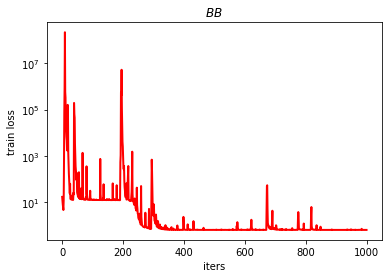

In [ ]:
plt.semilogy(iter_list0, train_loss_list0, 'r-', label = 'BB',  lw = 2)
plt.title(r'$BB$')
plt.xlabel('iters')
plt.ylabel('train loss')

Text(0, 0.5, 'test loss')

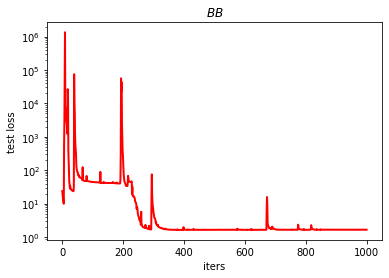

In [ ]:
plt.semilogy(iter_list0, valid_loss_list0, 'r-', label = 'BB', lw=2)
plt.title(r'$BB$')
plt.xlabel('iters')
plt.ylabel('test loss')

#BFGS

In [ ]:
def line_search_u(lam,df,cost,u,v,p,grad_u):
    '''
    BACKTRACK LINE SEARCH WITH WOLFE CONDITIONS
    '''
    a = 1
    c1 = 1e-4
    c2 = 0.9
    fx = cost(lam, df, u, v)
    u_new = u + a * p 
    grad_u_new, grad_v = gradient(df, u_new, v)
    i=0
    #for i in range(10):
    while cost(lam, df, u_new, v) > (fx + (c1*a*(-a*p).T@grad_u)).astype(float) and (grad_u_new.T@(-a*p)).astype(float) < (c2*grad_u.T@(-a*p)).astype(float):
    #while cost(lam, df, u_new, v) >= fx + (c1*a*grad_u.T@p) or grad_u_new.T@p <= c2*grad_u.T@p: 
        i += 1
        a *= 0.5
        u_new = u + a * p 
        grad_u_new, grad_v = gradient(df, u_new, v)
    print('ok')
    return a

In [ ]:
def line_search_v(lam,df,cost,v,u,p,grad_v):
    '''
    BACKTRACK LINE SEARCH WITH WOLFE CONDITIONS
    '''
    a = 1
    c1 = 1e-4
    c2 = 0.9
    fx = cost(lam, df, u, v)
    v_new = v + a * p 
    grad_u, grad_v_new = gradient(df, u, v_new)
    i=0
    #for i in range(10):
    while cost(lam, df, u, v_new) > (fx + (c1*a*(-a*p).T@grad_v)).astype(float) and (grad_v_new.T@(-a*p)).astype(float) < (c2*grad_v.T@(-a*p)).astype(float):
        #print(a, cost(lam, df, u, v_new), fx + (c1*a*(-a*p).T@grad_v), grad_v_new.T@(-a*p), c2*grad_v.T@(-a*p)) 
        i += 1
        a *= 0.5
        v_new = v + a * p 
        grad_u, grad_v_new = gradient(df, u, v_new)
    print('ok')
    return a

In [ ]:
from scipy.sparse.construct import random
# BB for general problem
def BFGS(lam, cost, df, u, v, outer_iterations, inner_iterations, df_val=None):
    #Y = create_sparse_matrix(df, random_u.shape[0], random_v.shape[0])
    grad_u, grad_v = gradient(df, u, v)
    H_u, H_v = np.eye(u.shape[0]), np.eye(v.shape[0])
    a_u, a_v = 1,1
    iter_list=[]
    train_loss_list=[]
    valid_loss_list=[]

    for iter in range(outer_iterations):
      for i in range(inner_iterations):
          if np.linalg.norm(grad_u) < 1e-5:
              print('Maximum iterations reached.')
              break
          p_u = -a_u*H_u@grad_u # search direction
          a_u = line_search_u(lam,df,cost,u,v,p_u,grad_u)
          s_u = a_u*p_u
          u_new = u + s_u
          grad_u_new, grad_v_new = gradient(df, u_new, v)
          y_u = grad_u_new - grad_u
          y_u = np.array([y_u])
          s_u = np.array([s_u])
          y_u = np.reshape(y_u,(u.shape[0],1))
          s_u = np.reshape(s_u,(u.shape[0],1))
          r_u = 1/s_u.T@y_u
          li_u = (np.eye(u.shape[0])-(r_u*((s_u@(y_u.T)))))
          ri_u = (np.eye(u.shape[0])-(r_u*((y_u@(s_u.T)))))
          hess_inter_u = li_u@H_u@ri_u
          H_u = hess_inter_u + (r_u*((s_u@(s_u.T)))) # BFGS Update
          grad_u = grad_u_new[:]
          u = u_new[:]
          print("update u"+"----"*5)
          print("train mse:",  cost(lam, df, u, v))
          train_loss_list.append(cost(lam, df, u, v))
          print("validation mse:",  cost(lam, test_set, u, v))
          valid_loss_list.append(cost(lam, test_set, u, v))
          iter_list.append(i)

      for i in range(inner_iterations):
          if np.linalg.norm(grad_v) < 1e-5:
              print('Maximum iterations reached.')
              break
          p_v = -a_v*H_v@grad_v # search direction
          a_v = line_search_v(lam,df,cost,v,u,p_v,grad_v)
          s_v = a_v*p_v
          v_new = v + s_v
          grad_u_new, grad_v_new = gradient(df, u, v_new)
          
          y_v = grad_v_new - grad_v
          y_v = np.array([y_v])
          s_v = np.array([s_v])
          y_v = np.reshape(y_v,(v.shape[0],1))
          s_v = np.reshape(s_v,(v.shape[0],1))
          r_v = 1/s_v.T@y_v
          li_v = (np.eye(v.shape[0])-(r_v*((s_v@(y_v.T)))))
          ri_v = (np.eye(v.shape[0])-(r_v*((y_v@(s_v.T)))))
          hess_inter_v = li_v@H_v@ri_v
          H_v = hess_inter_v + (r_v*((s_v@(s_v.T)))) # BFGS Update
          grad_v = grad_v_new[:]
          v = v_new[:]
          #print(u.shape[0], v.shape[0])
          print("update v"+"----"*5)
          print("train mse:",  cost(lam, df, u, v))
          train_loss_list.append(cost(lam, df, u, v))
          print("validation mse:",  cost(lam, test_set, u, v))
          valid_loss_list.append(cost(lam, test_set, u, v))
          iter_list.append(i)
          '''
          if(not (i+1)%50):
              print("\niteration", i+1, ":")
              print("train mse:",  cost(lam, df, u, v))
              if df_val is not None:
                  print("validation mse:",  cost(lam, test_set, u, v))
          '''
    iter_list = list(range(0,len(iter_list)))
    return u, v, iter_list, train_loss_list, valid_loss_list

In [ ]:
u_bfgs, v_bfgs, iter_list1, train_loss_list1, valid_loss_list1 = BFGS(0.000002, cost, train_set, random_u, random_v, 10, 5, df_val=None)

Text(0, 0.5, 'train loss')

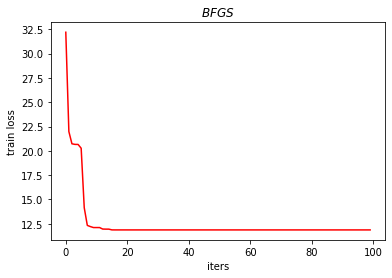

In [ ]:
plt.plot(iter_list1, train_loss_list1, 'r-', label = 'BFGS')
plt.title(r'$BFGS$')
plt.xlabel('iters')
plt.ylabel('train loss')

In [ ]:
plt.plot(iter_list1, valid_loss_list1, 'r-', label = 'BFGS')
plt.title(r'$BFGS$')
plt.xlabel('iters')
plt.ylabel( 'test loss')

# CD

In [16]:
def cd(A,u,v,lam,maxiters):
  print("train mse:",  cost(lam,train_set,u,v))
  iter_list=[]
  train_loss_list=[]
  valid_loss_list=[]
  for iter in range(maxiters):
    for i in range(u.shape[0]):
      #print(i)
      uk_up,uk_low = 0,0
      for j in range(v.shape[0]):
        uk_up += A[i,j]*v[j]
        uk_low += v[j]**2
      u[i] = uk_up/uk_low
    #print("train mse:",  cost(lam,train_set_for_sgd,u,v)) 

    for j in range(v.shape[0]):
      vt_up,vt_low = 0,0
      for i in range(u.shape[0]):
        vt_up += A[i,j]*u[i]
        vt_low += u[i]**2
      v[j] = vt_up/vt_low

    print("train mse:",  cost(lam,train_set,u,v))
    train_loss_list.append(cost(lam,train_set,u,v))
    print("validation mse:",  cost(lam, test_set, u, v))
    valid_loss_list.append(cost(lam, test_set, u, v))
    iter_list.append(i)     
  return u, v, iter_list, train_loss_list, valid_loss_list

In [ ]:
u_cd, v_cd, iter_list2, train_loss_list2, valid_loss_list2 = cd(train_set_den,random_u,random_v,0.000002,50)

In [ ]:
plt.plot(iter_list2, train_loss_list2, 'r-', label = 'CD')
plt.title(r'$CD$')
plt.xlabel('iters')
plt.ylabel('train loss')

In [ ]:
plt.plot(iter_list2, valid_loss_list2, 'r-', label = 'CD')
plt.title(r'$CD$')
plt.xlabel('iters')
plt.ylabel('test loss')

# ccd

In [32]:
def ccd(R,u,v,lam,maxiters):
  k = u.shape[1]
  iter_list=[0]
  train_loss_list=[cost(lam,train_set,u,v)]
  valid_loss_list=[cost(lam,test_set,u,v)]
  #u = np.zeros((671, k))
  print("train mse:",  cost(lam,train_set,u,v))
  for iter in range(maxiters):
    for i in range(u.shape[0]):
      for t in range(k):
        z_star_up, z_star_low = 0,0
        for j in range(v.shape[0]):
          z_star_up += (R[i,j]+u[i][t]*v[j][t])*v[j][t]
          z_star_low += v[j][t]**2
        z_star = (z_star_up)/(lam + z_star_low)
        for j in range(v.shape[0]):
          R[i,j] = R[i,j]-(z_star-u[i][t])*v[j][t]
        u[i][t]=z_star

    for j in range(v.shape[0]):
      for t in range(k):
        s_star_up, s_star_low = 0,0
        for i in range(u.shape[0]):
          s_star_up += (R[i,j]+u[i][t]*v[j][t])*u[i][t]
          s_star_low += u[i][t]**2        
        s_star = s_star_up/(lam + s_star_low)
        for i in range(u.shape[0]):
          R[i,j] = R[i,j]-(s_star-v[j][t])*u[i][t]
        v[j][t]=s_star
        
    iter_list.append(iter)
    train_loss_list.append(cost(lam,train_set,u,v))
    valid_loss_list.append(cost(lam,test_set,u,v))
    print("train mse:",  cost(lam,train_set,u,v))
    print("validation mse:",  cost(lam,test_set,u,v))

  return u,v,R,iter_list, train_loss_list, valid_loss_list

In [ ]:
u_ccd,v_ccd,R,iter_list3, train_loss_list3, valid_loss_list3 = ccd(train_set_den,random_u,random_v,0.000002,30)

Text(0, 0.5, 'train loss')

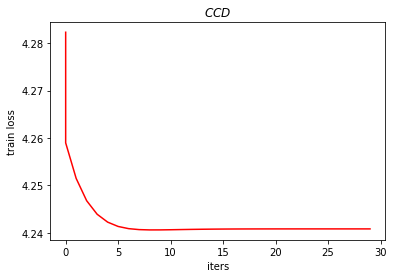

In [36]:
plt.plot(iter_list3, train_loss_list3, 'r-', label = 'CCD')
plt.title(r'$CCD$')
plt.xlabel('iters')
plt.ylabel('train loss')

Text(0, 0.5, 'test loss')

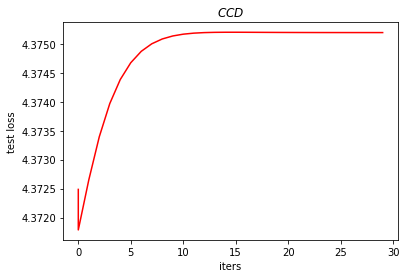

In [37]:
plt.plot(iter_list3, valid_loss_list3, 'r-', label = 'CCD')
plt.title(r'$CCD$')
plt.xlabel('iters')
plt.ylabel('test loss')

#ccd+

In [16]:
def ccd(R,u,v,lam,maxiters,k):
  iter_list1 = []
  loss_list1 = []
  valid_loss_list1 = []
  #u = np.zeros((671, k))
  print("train mse:",  cost(lam,train_set,u,v))
  for iter in range(maxiters):
    for i in range(u.shape[0]):
      for t in range(k):
        z_star_up, z_star_low = 0,0
        for j in range(v.shape[0]):
          z_star_up += (R[i,j]+u[i][t]*v[j][t])*v[j][t]
          z_star_low += v[j][t]**2
        z_star = (z_star_up)/(lam+z_star_low)
        for j in range(v.shape[0]):
          R[i,j] = R[i,j]-(z_star-u[i][t])*v[j][t]
        u[i][t]=z_star

    for j in range(v.shape[0]):
      for t in range(k):
        s_star_up, s_star_low = 0,0
        for i in range(u.shape[0]):
          s_star_up += (R[i,j]+u[i][t]*v[j][t])*u[i][t]
          s_star_low += u[i][t]**2        
        s_star = s_star_up/(lam+s_star_low)
        for i in range(u.shape[0]):
          R[i,j] = R[i,j]-(s_star-v[j][t])*u[i][t]
        v[j][t]=s_star
    iter_list1.append(iter)
    loss_list1.append(cost(lam,train_set,u,v))
    valid_loss_list1.append(cost(lam,test_set,u,v))
    print("train mse:",  cost(lam,train_set,u,v))
    #print("validation mse:",  cost(lam,train_set_for_sgd,u,v))

  return u,v,R,iter_list1,loss_list1,valid_loss_list1

In [17]:
def ccdplus(R,u,v,lam,maxiters,T,k):
  iter_list2 = [0]
  loss_list2 = [[cost(lam,train_set,u,v)]]
  valid_loss_list2 = [[cost(lam,test_set,u,v)]]
  w_hat,h_hat = u,v
  for iter in range(maxiters):
    for t in range(k):
      u_star, v_star, R_hat, iter_list1, loss_list1,valid_loss_list1 = ccd(R,w_hat,h_hat,lam,T,k)
      for i in range(u.shape[0]):
        for j in range(v.shape[0]):
          R[i,j] = R_hat[i,j]-u_star[i]@v_star[j]
      w_hat, h_hat = u_star, v_star
    iter_list2.append(iter_list1)
    loss_list2.append(loss_list1)
    valid_loss_list2.append(valid_loss_list1)
  iter_list2 = list(range(0,len(iter_list2)))
  loss_list2 = [item for sublist in loss_list2 for item in sublist]
  valid_loss_list2 = [item for sublist in valid_loss_list2 for item in sublist]
  print("train mse_plus:",  cost(lam,train_set,w_hat,h_hat))

  return u_star, v_star, R, iter_list2, loss_list2, valid_loss_list2

In [ ]:
u_star, v_star, R, iter_list4, train_loss_list4, valid_loss_list4 = ccdplus(train_set_den,random_u,random_v,0.000002,5,5,1)

Text(0, 0.5, 'test loss')

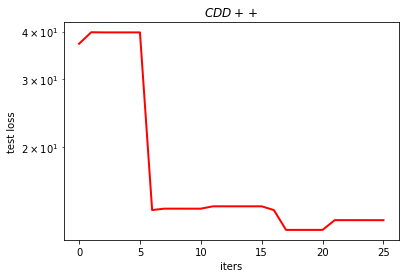

In [29]:
plt.semilogy(iter_list4, train_loss_list4, 'r-', label = 'CCD+',  lw = 2)
plt.title(r'$CDD++$')
plt.xlabel('iters')
plt.ylabel('test loss')

Text(0, 0.5, 'test loss')

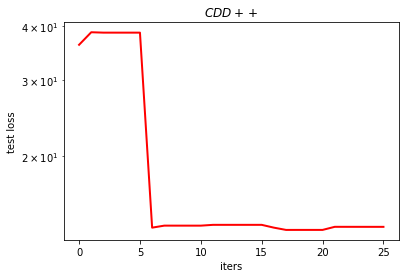

In [30]:
plt.semilogy(iter_list4, valid_loss_list4, 'r-', label = 'CCD+',  lw = 2)
plt.title(r'$CDD++$')
plt.xlabel('iters')
plt.ylabel('test loss')

# Validation matrix

In [ ]:
def encode_new_data(valid_df, user_ids, moive_ids):
    """ Encodes valid_df with the same encoding as train_df.
    """
    df_val_chosen = valid_df['movieId'].isin(moive_ids.keys()) & valid_df['userId'].isin(user_ids.keys())
    valid_df = valid_df[df_val_chosen]
    valid_df['movieId'] =  np.array([moive_ids[x] for x in valid_df['movieId']])
    valid_df['userId'] = np.array([user_ids[x] for x in valid_df['userId']])
    return valid_df

In [ ]:
print("before encoding:", test_set.shape)
valid_df = encode_new_data(test_set, user_ids, movie_ids)
print("after encoding:", valid_df.shape)

before encoding: (20001, 4)
after encoding: (15182, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train_mse = cost(0.000002, train_set, random_u, random_v)
val_mse = cost(0.000002, valid_df, random_u, random_v)
print(train_mse, val_mse)

In [ ]:
#looking at the predictions
valid_df[80:130].head(15)

,userId,movieId,rating,prediction
87,60,1677,4.5,1.596846
88,556,3656,4.0,6.274621
89,209,2131,5.0,0.937362
90,160,4733,5.0,14.083155
91,355,2854,3.0,5.574035
92,589,2110,3.0,17.989332
93,419,2897,4.5,1.202392
94,398,3649,3.0,6.490876
95,479,2322,2.0,2.874367
98,361,3972,4.0,1.190482
